In [1]:
!pip install datasets
!pip install accelerate -U
#!pip install peft -U
!pip install evaluate
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import random
import torch
import matplotlib.pyplot as plt
import os
import shutil
import gc
import json
import torch
import shutil
import argparse
from tqdm import tqdm
from os.path import join, exists
from collections import defaultdict
from transformers import GPT2Tokenizer, GPT2Model, GPT2Config, GPT2ForSequenceClassification, set_seed
from transformers import AutoTokenizer, Trainer, TrainingArguments
from transformers import TrainingArguments, Trainer, EvalPrediction, TrainerCallback, TrainerControl, TrainerState
from datasets import load_dataset, load_metric, Dataset
import numpy as np
import evaluate

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 7.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x8

In [2]:
data = pd.read_csv('cc_data_seq.csv')
data['Event'] = data['Event'].str.replace('0_0_0,', '', regex=False)
data['Event'] = data['Event'].str.replace('start,', '', regex=False)
data['Event'] = data['Event'].str.replace('end', '', regex=False)
data['Response'] = data['Response'].astype(int)
def add_two_to_numbers(s):
    parts = s.split('_')
    if len(parts)>1:
        parts = [str(int(part) + 2) for part in parts]
        return ''.join(parts)
    else:
        return s

def tokenize_function(examples, tokenizer):
    """
    Tokenize the events and map labels appropriately.
    """
    result = tokenizer(examples['Event'], padding="max_length", max_length=tokenizer.model_max_length, truncation=True)
    # Attach the labels from the dataset
    result['labels'] = examples['Response']
    return result

# tokenizer = GPT2Tokenizer.from_pretrained('distilgpt2')
# tokenizer.pad_token = tokenizer.eos_token
data['Event'] = data['Event'].apply(lambda y: ','.join([add_two_to_numbers(x) for x in y.split(',')]))
print(data.head(), len(data))

dataset = Dataset.from_pandas(data)
# tokenized_dataset = dataset.map(lambda x: tokenize_function(x, tokenizer), batched=True)

        Unnamed: 0               ID  Response  \
0  ARE000000200039  ARE000000200039         0   
1  ARE000000200051  ARE000000200051         1   
2  ARE000000300079  ARE000000300079         1   
3  ARE000000400093  ARE000000400093         1   
4  ARE000000400117  ARE000000400117         0   

                                               Event  \
0  340,444,444,444,444,444,440,440,400,000,000,00...   
1  reset,122,112,111,122,122,reset,422,reset,242,...   
2                 333,reset,223,reset,232,reset,322,   
3  322,reset,223,224,reset,232,242,142,reset,422,...   
4                           040,000,111,422,242,224,   

                                                Time  
0  0,49.3,55.9,61.7,62.6,63.2,63.5,63.9,66.4,68.4...  
1  0,98.9,151.9,156.7,160.5,164.8,165.8,166.7,170...  
2      0,113.2,119.1,122,135.4,138.5,147.8,149.8,157  
3  0,36.9,41.2,43.3,44.5,50.5,61.9,66.1,68.7,72.3...  
4  0,59.9,91.8000000000001,99.6999999999999,113.1...   16763


In [3]:
def prepare_model_and_tokenizer(model_name, num_labels: int):
    if "gpt2" in model_name:
        model = GPT2ForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
        tokenizer = GPT2Tokenizer.from_pretrained(model_name)
        tokenizer.pad_token = tokenizer.eos_token
        model.config.pad_token_id = tokenizer.eos_token_id
    else:
        raise NotImplementedError("Model not implemented!")
    return model, tokenizer

def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    preds = np.argmax(preds, axis=1)
    return {"accuracy": (preds == p.label_ids).astype(np.float32).mean().item()}

def FT_gpt(num_train, num_val, seed, model_name = 'distilgpt2', num_labels = 2, train_batch_size = 20):
    accumulation_steps = num_train // train_batch_size
    if os.path.exists(f"./{model_name}"):
        shutil.rmtree(f"./{model_name}")
    set_seed(seed)
    model, tokenizer = prepare_model_and_tokenizer(model_name, num_labels)
    model.to(device)
    tokenized_dataset = dataset.map(lambda x: tokenize_function(x, tokenizer), batched=True)
    tokenized_dataset = tokenized_dataset.shuffle(seed=seed)
    train_dataset = tokenized_dataset.select(range(num_train))
    eval_dataset = tokenized_dataset.select(range(num_train, num_train+num_val))
    test_dataset = tokenized_dataset.select(range(num_train+num_val, len(tokenized_dataset)))
    training_args = TrainingArguments(
        output_dir=f"./{model_name}",
        num_train_epochs=80,                              # Number of training epochs
        per_device_train_batch_size=train_batch_size,     # Batch size for training
        per_device_eval_batch_size=20,                    # Batch size for evaluation
        eval_steps=10,                                    # Number of update steps between two evaluations
        save_steps=10,                                   # After how many steps model is saved
        warmup_steps=10,                                 # Number of warmup steps for learning rate scheduler
        logging_dir='./logs',
        logging_steps=10,
        evaluation_strategy="steps",
        save_total_limit=2,
        load_best_model_at_end=True,
        metric_for_best_model="eval_accuracy",
        fp16=True,  # Enable FP16 training
        gradient_accumulation_steps=accumulation_steps,    # Accumulate gradients such that it implements full-batch GD
        learning_rate=8e-5,
        weight_decay=1e-4,
        max_grad_norm=2.0,
        seed=42,
    )
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        compute_metrics=compute_metrics,
        tokenizer=tokenizer,
    )
    trainer.train()
    test_result = trainer.evaluate(test_dataset)
    print("Test Accuracy:", test_result["eval_accuracy"])
    trainer.save_model(f"./{model_name}_{num_train}_{num_val}")
    return test_result["eval_accuracy"]

In [4]:
num_val = 4000
seed = 42
test_acc_list = []
for num_train in range(40, 440, 40):
    print(f"Num_train: {num_train} :")
    result = FT_gpt(num_train, num_val, seed)
    test_acc_list.append(result)

Num_train: 40 :


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at distilgpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/16763 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
10,2.068800,1.033695,0.597750
20,0.458100,0.793546,0.711250
30,0.061600,1.385914,0.722750
40,0.009500,1.874773,0.726250
50,0.002800,2.283136,0.717500
60,0.002400,2.915880,0.704750
70,0.001700,2.806467,0.714500
80,0.001200,2.719550,0.727000


Test Accuracy: 0.7293091416358948
Num_train: 80 :


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at distilgpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/16763 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
10,1.675500,1.198189,0.493750
20,0.589200,0.648900,0.726750
30,0.314400,0.895308,0.706000
40,0.166400,1.158638,0.680750
50,0.099000,1.501724,0.690750
60,0.086300,1.665050,0.692500
70,0.060700,1.668728,0.693000
80,0.051300,1.736365,0.691000


Test Accuracy: 0.7331861257553101
Num_train: 120 :


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at distilgpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/16763 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
10,1.741200,0.984724,0.586250
20,0.529100,0.602699,0.761750
30,0.270100,0.831630,0.758000
40,0.148400,1.256039,0.741500
50,0.115300,1.398530,0.736500
60,0.085900,1.573768,0.743750
70,0.079700,1.682776,0.731250
80,0.083600,1.744652,0.716000


Test Accuracy: 0.7699912786483765
Num_train: 160 :


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at distilgpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/16763 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
10,1.503300,0.744865,0.672000
20,0.477400,0.558357,0.774000
30,0.280800,0.834940,0.762250
40,0.197700,0.872234,0.764000
50,0.135800,1.167489,0.752000
60,0.110500,1.305827,0.753250
70,0.093700,1.428724,0.754000
80,0.087400,1.473382,0.757500


Test Accuracy: 0.780290424823761
Num_train: 200 :


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at distilgpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/16763 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
10,1.513900,0.720847,0.677500
20,0.467600,0.533403,0.789500
30,0.286000,0.731708,0.781000
40,0.192700,0.990245,0.774250
50,0.150100,1.112359,0.769250
60,0.127300,1.257041,0.764250
70,0.108000,1.406601,0.759250
80,0.113100,1.452966,0.768750


Test Accuracy: 0.7926450967788696
Num_train: 240 :


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at distilgpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/16763 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
10,1.543200,0.706450,0.672750
20,0.497100,0.509033,0.793500
30,0.364400,0.607226,0.778000
40,0.260700,0.800126,0.760250
50,0.216900,0.923943,0.772750
60,0.170500,0.966358,0.779250
70,0.149100,1.108221,0.775250
80,0.134800,1.164204,0.774000


Test Accuracy: 0.7946977615356445
Num_train: 280 :


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at distilgpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/16763 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
10,1.390700,0.572893,0.724500
20,0.493800,0.508694,0.791250
30,0.352800,0.614192,0.757250
40,0.251400,0.749457,0.764750
50,0.186100,0.874137,0.768750
60,0.142300,1.113829,0.752500
70,0.129200,1.210212,0.758500
80,0.115900,1.250819,0.763250


Test Accuracy: 0.7963630557060242
Num_train: 320 :


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at distilgpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/16763 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
10,1.430100,0.634747,0.719500
20,0.508000,0.502412,0.801500
30,0.387600,0.540283,0.800500
40,0.300600,0.666062,0.773500
50,0.218500,0.834544,0.774750
60,0.176400,0.951339,0.752000
70,0.154200,1.064467,0.754750
80,0.134300,1.067346,0.761250


Test Accuracy: 0.802539587020874
Num_train: 360 :


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at distilgpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/16763 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
10,1.412500,0.592232,0.722000
20,0.495200,0.493884,0.805250
30,0.367500,0.565941,0.794500
40,0.289900,0.669071,0.791500
50,0.216800,0.859790,0.788500
60,0.174500,1.057792,0.775500
70,0.145300,1.104076,0.780750
80,0.142900,1.170142,0.778250


Test Accuracy: 0.806579053401947
Num_train: 400 :


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at distilgpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/16763 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
10,1.410000,0.579805,0.734500
20,0.459100,0.506575,0.804750
30,0.361800,0.568229,0.791750
40,0.280100,0.711172,0.781750
50,0.212300,0.824368,0.786000
60,0.170600,0.961134,0.777500
70,0.152000,0.978191,0.778250
80,0.139000,0.963299,0.783500


Test Accuracy: 0.8056297302246094


In [5]:
print(test_acc_list)

[0.7293091416358948, 0.7331861257553101, 0.7699912786483765, 0.780290424823761, 0.7926450967788696, 0.7946977615356445, 0.7963630557060242, 0.802539587020874, 0.806579053401947, 0.8056297302246094]


In [7]:
test_acc_list_copy = [0.7293091416358948, 0.7331861257553101, 0.7699912786483765, 0.780290424823761, 0.7926450967788696, 0.7946977615356445, 0.7963630557060242, 0.802539587020874, 0.806579053401947, 0.8056297302246094]

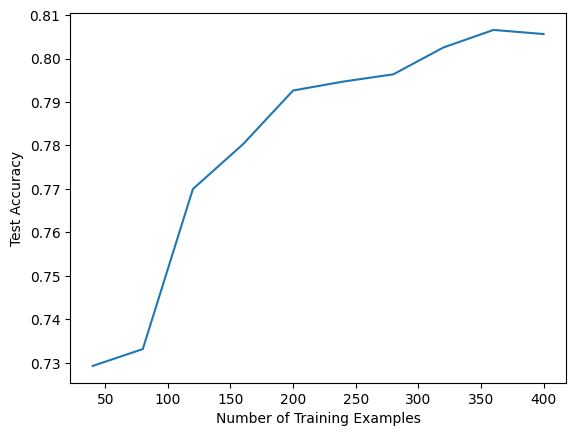

In [6]:
plt.plot(range(40, 440, 40), test_acc_list)
plt.xlabel('Number of Training Examples')
plt.ylabel('Test Accuracy')
plt.show()